In [ ]:
# import Libraries

import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler 
from random import sample

In [ ]:
from numpy.random import seed
seed(1)

import tensorflow
tensorflow.random.set_seed(2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path='/content/drive/My Drive/BVD/Train'
val_path='/content/drive/My Drive/BVD/Val'
test_path='/content/drive/My Drive/BVD/Test'

In [ ]:
df_train=pd.DataFrame(columns=['path','label'])
df_val=pd.DataFrame(columns=['path','label'])
df_test=pd.DataFrame(columns=['path','label'])

In [ ]:
os.listdir(train_path)

['Drone', 'Bird']

In [ ]:
IMAGE_SAMPLES=None      # Pass image samples as None to take all samples of images

# CHOOSE 1 OF THE CATEGORIES

# categories=['Bread','Dessert','Meat','Soup']    # only 4 categories
categories=os.listdir(train_path)          # list of all categories

def limit_data(data_dir,categories,n=None):
    '''
    This function limits the number of samples in each class and return the dataframe
    '''
    a=[]
    for i in categories:
        for k,j in enumerate(os.listdir(data_dir+'/'+i)):
            if n!=None and k>=n:break;
            a.append((f'{data_dir}/{i}/{j}',i))
    return pd.DataFrame(a,columns=['path','label'])


df_train=limit_data(train_path,categories,IMAGE_SAMPLES)
df_val=limit_data(val_path,categories,IMAGE_SAMPLES)
df_test=limit_data(test_path,categories,IMAGE_SAMPLES)

In [ ]:
df_train['label'].value_counts()

Drone    308
Bird     300
Name: label, dtype: int64

In [ ]:
df_val['label'].value_counts()

Drone    60
Bird     50
Name: label, dtype: int64

In [ ]:
df_test['label'].value_counts()

Drone    60
Bird     50
Name: label, dtype: int64

In [ ]:
df_train=df_train.sample(frac=1)
df_val=df_val.sample(frac=1)
df_test=df_test.sample(frac=1)

In [ ]:
df_train

,path,label
65,/content/drive/My Drive/BVD/Train/Drone/287.JPEG,Drone
237,/content/drive/My Drive/BVD/Train/Drone/63.JPEG,Drone
147,/content/drive/My Drive/BVD/Train/Drone/187.JPEG,Drone
465,/content/drive/My Drive/BVD/Train/Bird/singleB...,Bird
187,/content/drive/My Drive/BVD/Train/Drone/54.JPEG,Drone
...,...,...
129,/content/drive/My Drive/BVD/Train/Drone/272.JPEG,Drone
144,/content/drive/My Drive/BVD/Train/Drone/220.JPEG,Drone
72,/content/drive/My Drive/BVD/Train/Drone/257.JPEG,Drone
235,/content/drive/My Drive/BVD/Train/Drone/49.JPEG,Drone


In [ ]:
df_val

,path,label
57,/content/drive/My Drive/BVD/Val/Drone/singleDr...,Drone
66,/content/drive/My Drive/BVD/Val/Bird/singleBir...,Bird
49,/content/drive/My Drive/BVD/Val/Drone/singleDr...,Drone
36,/content/drive/My Drive/BVD/Val/Drone/singleDr...,Drone
98,/content/drive/My Drive/BVD/Val/Bird/singleBir...,Bird
...,...,...
21,/content/drive/My Drive/BVD/Val/Drone/singleDr...,Drone
94,/content/drive/My Drive/BVD/Val/Bird/singleBir...,Bird
34,/content/drive/My Drive/BVD/Val/Drone/singleDr...,Drone
22,/content/drive/My Drive/BVD/Val/Drone/singleDr...,Drone


In [ ]:
df_test

,path,label
8,/content/drive/My Drive/BVD/Test/Drone/video18...,Drone
11,/content/drive/My Drive/BVD/Test/Drone/video14...,Drone
9,/content/drive/My Drive/BVD/Test/Drone/yoto029...,Drone
29,/content/drive/My Drive/BVD/Test/Drone/singleD...,Drone
17,/content/drive/My Drive/BVD/Test/Drone/video16...,Drone
...,...,...
103,/content/drive/My Drive/BVD/Test/Bird/singleBi...,Bird
43,/content/drive/My Drive/BVD/Test/Drone/video14...,Drone
37,/content/drive/My Drive/BVD/Test/Drone/yoto028...,Drone
38,/content/drive/My Drive/BVD/Test/Drone/video14...,Drone


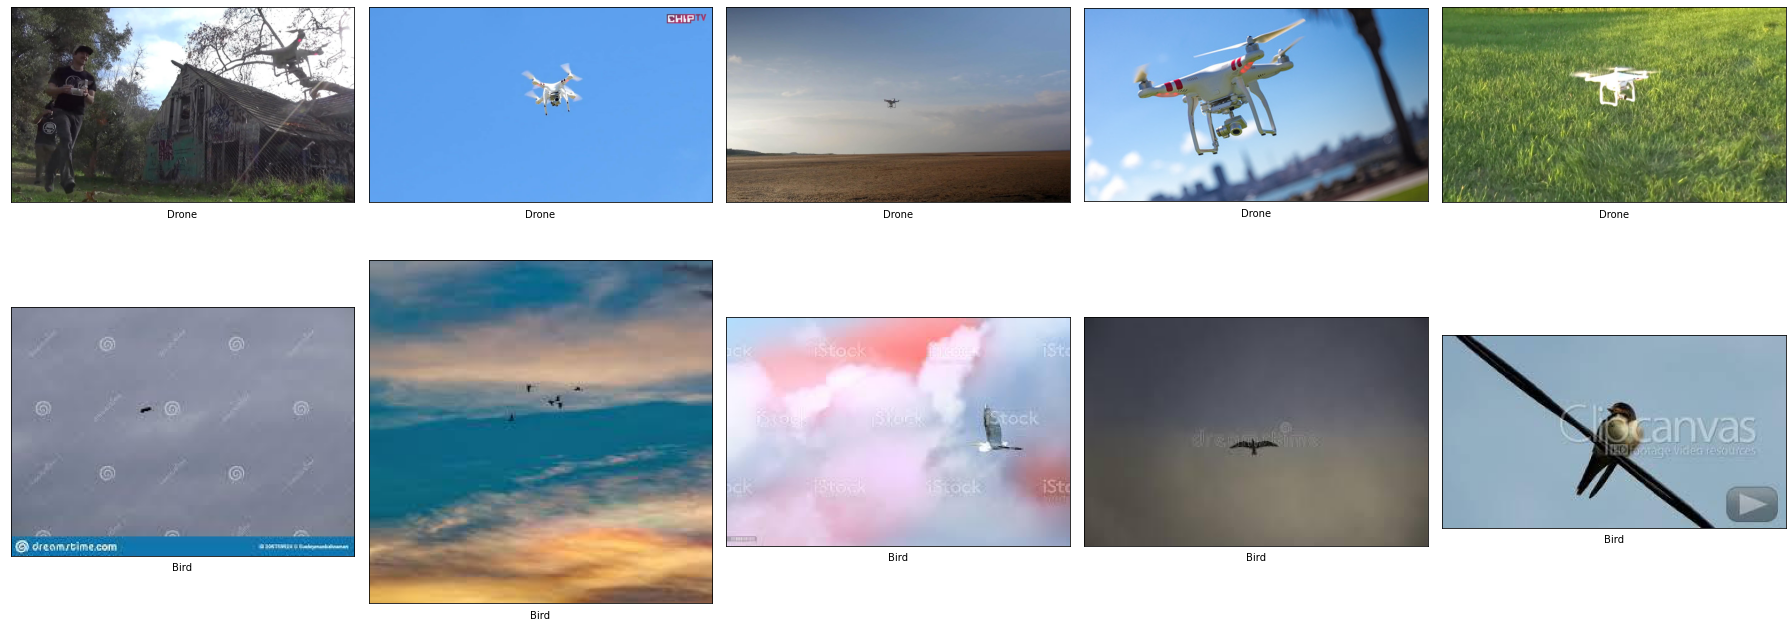

In [ ]:
# Randomly display 5 images under each of the 4 categories from the training data.
# You will see different images each time.
fig, axs = plt.subplots(len(df_train['label'].unique()), 5, figsize = (25, 10))
for i,cat in enumerate(categories):
    path_cat=df_train[df_train['label']==cat].path.values[:5]        # take only 5 categories
    for j, path in enumerate(path_cat):
#         images = sample(df_train[item], 5)

        img = PIL.Image.open(path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel = cat, xticks = [], yticks = [])

fig.tight_layout()

In [ ]:
# Image generator with Augmentation
train_datagen = ImageDataGenerator(rescale=1./255)

train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    zoom_range = 0.2,
    horizontal_flip = True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.8,1.0]
)

val_datagen=ImageDataGenerator(rescale=1./255)

# For test data we only rescale the data.
# Never augment test data!!!
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
#without augmentation
train_data=train_datagen.flow_from_dataframe(df_train,x_col='path',y_col='label',target_size=(256, 256),batch_size=32,
                                             class_mode='binary',seed=42)


val_data=val_datagen.flow_from_dataframe(df_val,x_col='path',y_col='label',target_size=(256, 256),batch_size=32,
                                           class_mode='binary',seed=42,shuffle = False)


# augmentation
train_data_aug=train_datagen_aug.flow_from_dataframe(df_train,x_col='path',y_col='label',target_size=(256, 256),
                                                     batch_size=32,class_mode='binary',seed=42)


#test data
test_data=test_datagen.flow_from_dataframe(df_test,x_col='path',y_col='label',target_size=(256, 256),batch_size=32,
                                           class_mode='binary',seed=42,shuffle = False)

Found 606 validated image filenames belonging to 2 classes.
Found 110 validated image filenames belonging to 2 classes.
Found 606 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


Found 110 validated image filenames belonging to 2 classes.


In [ ]:
# Which class belongs to which label
train_data.class_indices

{'Bird': 0, 'Drone': 1}

# Show Augmented images

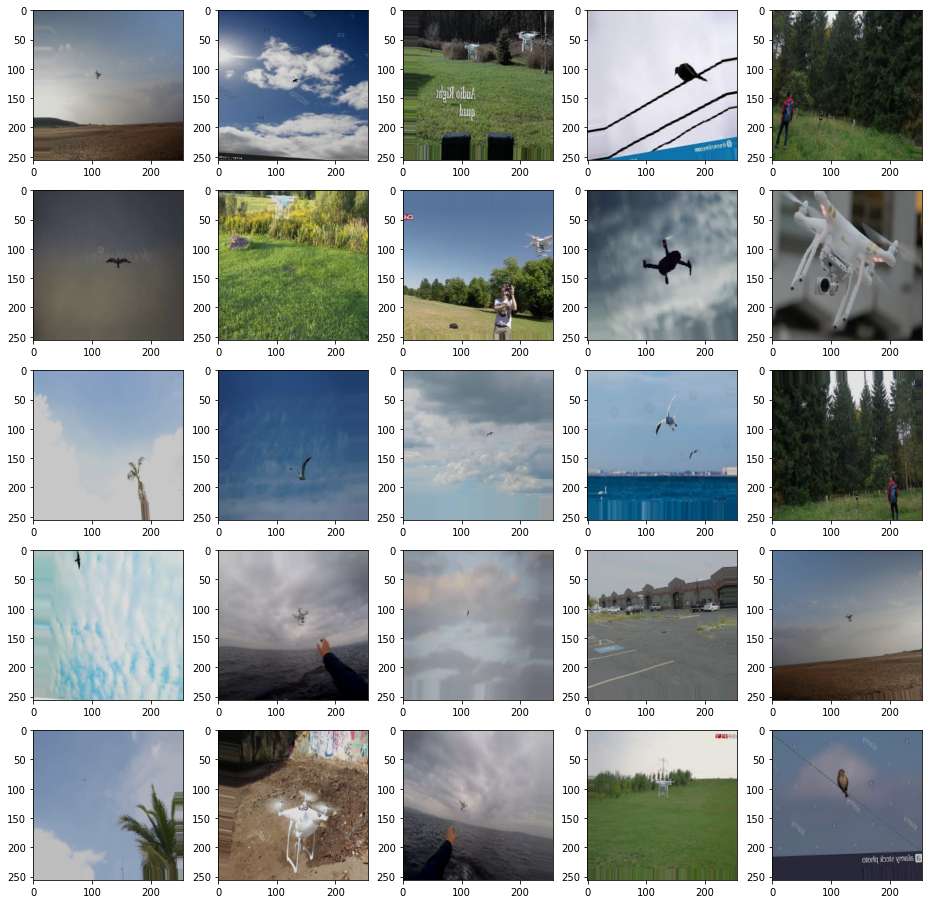

In [ ]:
w = 10
h = 10

x= train_data_aug.next()
image = x[0]      # img=x[0], label=x[1]
fig = plt.figure(figsize=(16, 16))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = image[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [ ]:
import itertools,matplotlib
from itertools import product

min_val, max_val = 0.3,1.0
n = 10
orig_cmap = plt.cm.Blues
colors = orig_cmap(np.linspace(min_val, max_val, n))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors)


def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=cmap):

    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Training the model

In [ ]:
input_layer=Input(shape=(256,256,3))

layer=Conv2D(filters=128,kernel_size=(3,3),activation="relu")(input_layer)
layer=MaxPool2D(pool_size=(2,2),strides=(1,1))(layer)
layer=BatchNormalization()(layer)
# layer=Dropout(0.6)(layer)

layer=Conv2D(filters=64,kernel_size=(3,3),activation="relu")(layer)
layer=MaxPool2D(pool_size=(2,2),strides=(1,1))(layer)
layer=BatchNormalization()(layer)
# layer=Dropout(0.6)(layer)

layer=Conv2D(filters=32,kernel_size=(3,3),activation="relu")(layer)
layer=MaxPool2D(pool_size=(2,2),strides=(1,1))(layer)
layer=BatchNormalization()(layer)
# layer=Dropout(0.6)(layer)

layer=Conv2D(filters=16,kernel_size=(3,3),activation="relu")(layer)
layer=MaxPool2D(pool_size=(2,2),strides=(1,1))(layer)
layer=BatchNormalization()(layer)
# layer=Dropout(0.6)(layer)

layer=Flatten()(layer)
layer=Dense(256,activation="relu")(layer)
layer=Dense(128,activation="relu")(layer)
layer=Dense(64,activation="relu")(layer)
layer=Dense(32,activation="relu")(layer)
output_layer=Dense(1,activation="sigmoid")(layer)

In [ ]:
model=Model(inputs=input_layer,outputs=output_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 253, 253, 128)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 253, 253, 128)    512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 251, 251, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 250, 250, 64)     0     

In [ ]:
model_aug=Model(inputs=input_layer,outputs=output_layer)
model_aug.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 253, 253, 128)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 253, 253, 128)    512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 251, 251, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 250, 250, 64)     0   

In [ ]:
# def exp_decay(epoch):
#    initial_lrate = 0.001
#    k = 0.1
#    lrate = initial_lrate * np.exp(-k*t)
#    return lrate

# lrate =  tf.keras.callbacks.LearningRateScheduler(exp_decay)

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-3 * 10**(epoch/25)
# )

In [ ]:
model.compile(loss='binary_crossentropy',
       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
       metrics=['accuracy','AUC'])

model_aug.compile(loss='binary_crossentropy',
       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
       metrics=['accuracy','AUC'])

# Without augmentation

In [ ]:
history = model.fit(
    train_data,
    epochs=25,
    validation_data=val_data
#     callbacks=[lr_schedule]
)

Epoch 1/25
19/19 [==============================] - 1353s 71s/step - loss: 29.7767 - accuracy: 0.6832 - auc: 0.7000 - val_loss: 13.0675 - val_accuracy: 0.4636 - val_auc: 0.5170
Epoch 2/25
19/19 [==============================] - 1287s 68s/step - loss: 13.6871 - accuracy: 0.7591 - auc: 0.7772 - val_loss: 7.0788 - val_accuracy: 0.5455 - val_auc: 0.6202
Epoch 3/25


# Training curve

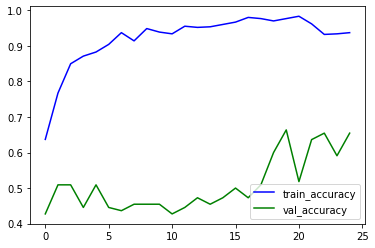

In [ ]:
hist=history.history
plt.plot(hist["accuracy"],color="b",label="train_accuracy")
plt.plot(hist["val_accuracy"],color="g",label="val_accuracy")
plt.legend(loc="lower right")
plt.show()

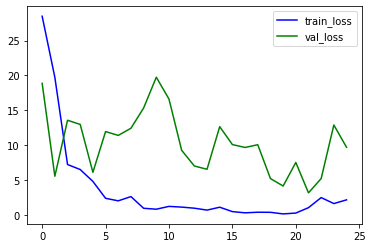

In [ ]:
#Loss curve
hist=history.history
plt.plot(hist["loss"],color="b",label="train_loss")
plt.plot(hist["val_loss"],color="g",label="val_loss")
plt.legend(loc="upper right")
plt.show()

In [ ]:
model.evaluate(train_data)

19/19 [==============================] - 9s 484ms/step - loss: 4.8369 - accuracy: 0.8168 - auc: 0.8489


[4.836917400360107, 0.8168317079544067, 0.8488678932189941]

In [ ]:
model.evaluate(val_data)

4/4 [==============================] - 0s 82ms/step - loss: 9.6894 - accuracy: 0.6545 - auc: 0.6738


[9.689419746398926, 0.6545454263687134, 0.6738333702087402]

In [ ]:
model.evaluate(test_data)

4/4 [==============================] - 1s 225ms/step - loss: 7.8044 - accuracy: 0.7091 - auc: 0.7633


[7.804423809051514, 0.7090908885002136, 0.7633333206176758]

In [ ]:
y_test_pred=model.predict(test_data)

In [ ]:
y_true=pd.Series(test_data.classes)
y_true

0      0
1      0
2      0
3      0
4      0
      ..
105    1
106    0
107    0
108    0
109    0
Length: 110, dtype: int64

In [ ]:
print(len(y_test_pred))
# print(y_test_pred[:20])

110


In [ ]:
auc=metrics.roc_auc_score(y_true,y_test_pred)
auc

0.7656666666666666

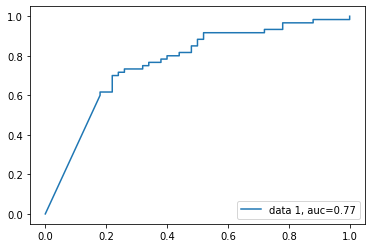

Threshold value is: 0.99901724


In [ ]:
# calculate roc curve
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_test_pred)

#plot the roc curve
plt.plot(fpr,tpr,label="data 1, auc="+str(round(auc,2)))
plt.legend(loc=4)
plt.show()

# find optimal threshold
# optimal_idx = np.argmax(tpr - fpr)
# optimal_threshold = thresholds[optimal_idx]
# print("Threshold value is:", optimal_threshold)

In [ ]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
gmeans

array([0.        , 0.70142712, 0.71110243, 0.69354164, 0.73891813,
       0.7293833 , 0.73801536, 0.72823989, 0.73665913, 0.70616334,
       0.71414284, 0.70356236, 0.71133677, 0.68944422, 0.69689789,
       0.68556546, 0.69282032, 0.66932802, 0.67626425, 0.65166454,
       0.66483081, 0.65192024, 0.66458007, 0.65115282, 0.66332496,
       0.50662281, 0.51120772, 0.45313721, 0.46115796, 0.41713307,
       0.36787679, 0.34058773, 0.34351128, 0.        , 0.        ])

In [ ]:
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
optimal_threshold=thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (optimal_threshold, gmeans[ix]))

Best Threshold=0.999736, G-Mean=0.739


In [ ]:
y_test_pred_index=[]
for i,pred in enumerate(y_test_pred):
    if pred>=optimal_threshold:
        y_test_pred_index.append(1)
    else:
        y_test_pred_index.append(0)
    
    
# print(y_test_pred_index)

In [ ]:
pd.Series(y_test_pred_index).value_counts()

0    59
1    51
dtype: int64

# Confusion matrix for No augmentation

In [ ]:
cm=confusion_matrix(y_true,y_test_pred_index)

Confusion matrix, without normalization


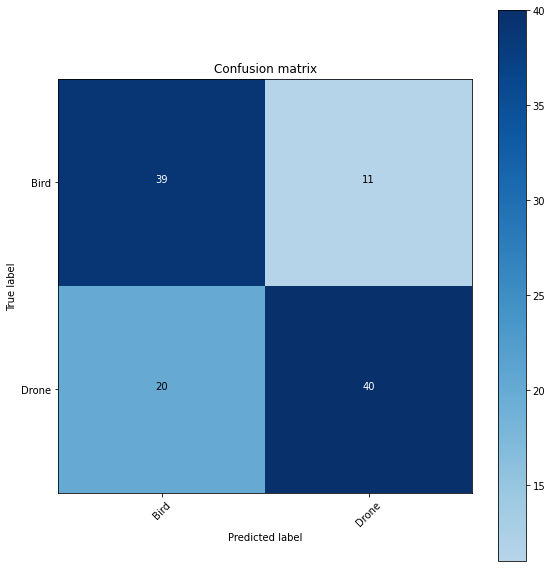

In [ ]:
plot_confusion_matrix(cm,classes=categories)

In [ ]:
cnt=0
for i in range(len(y_true)):
    if y_true[i]==y_test_pred_index[i]:
        cnt+=1

print('acc:', cnt/len(y_true)*100)
    

acc: 71.81818181818181


In [ ]:
print(len(y_true))

110


In [ ]:
print(list(y_true))
print(y_test_pred_index)

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1]


In [ ]:
metrics.accuracy_score(y_true,y_test_pred_index)

0.7181818181818181

### ClassWise accuracy without Augmentation

In [ ]:
class_wise_acc=cm.diagonal()/cm.sum(axis=0)


In [ ]:
for i,cat in enumerate(categories):
    print(f'Class wise {cat} accuracy :{np.round(class_wise_acc[i]*100,2)}')

Class wise Bird accuracy :66.1
Class wise Drone accuracy :78.43


# Augmentation model

In [ ]:
# Using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(
    monitor = 'loss', 
    verbose = 1, 
    patience = 4
)

In [ ]:
history_aug=model_aug.fit(
    train_data_aug,
    epochs=25,
    validation_data=val_data
#     callbacks=[earlystopping]
)

Epoch 1/25


2022-02-09 03:10:03.293805: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.38GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-02-09 03:10:03.294374: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


 1/19 [>.............................] - ETA: 38s - loss: 24.5442 - accuracy: 0.8125 - auc: 0.8294

2022-02-09 03:10:04.219133: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.38GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-02-09 03:10:04.220034: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


 2/19 [==>...........................] - ETA: 15s - loss: 17.4266 - accuracy: 0.7969 - auc: 0.8211

2022-02-09 03:10:05.133603: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.38GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-02-09 03:10:05.133839: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


 3/19 [===>..........................] - ETA: 14s - loss: 15.5063 - accuracy: 0.7812 - auc: 0.8056

2022-02-09 03:10:06.432173: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.38GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-02-09 03:10:06.433148: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


 4/19 [=====>........................] - ETA: 15s - loss: 18.2457 - accuracy: 0.7422 - auc: 0.7739

2022-02-09 03:10:07.271403: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.38GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-02-09 03:10:07.272263: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


19/19 [==============================] - 22s 1s/step - loss: 9.2309 - accuracy: 0.7459 - auc: 0.7683 - val_loss: 9.8582 - val_accuracy: 0.5091 - val_auc: 0.5153
Epoch 2/25
19/19 [==============================] - 21s 1s/step - loss: 4.9659 - accuracy: 0.7525 - auc: 0.7834 - val_loss: 27.2049 - val_accuracy: 0.4273 - val_auc: 0.4378
Epoch 3/25
19/19 [==============================] - 21s 1s/step - loss: 3.5808 - accuracy: 0.7360 - auc: 0.7779 - val_loss: 6.5904 - val_accuracy: 0.5727 - val_auc: 0.5895
Epoch 4/25
19/19 [==============================] - 20s 1s/step - loss: 3.8637 - accuracy: 0.7657 - auc: 0.8261 - val_loss: 5.6540 - val_accuracy: 0.6545 - val_auc: 0.7322
Epoch 5/25
19/19 [==============================] - 20s 1s/step - loss: 3.6570 - accuracy: 0.7442 - auc: 0.7970 - val_loss: 9.8885 - val_accuracy: 0.5364 - val_auc: 0.5250
Epoch 6/25
19/19 [==============================] - 20s 1s/step - loss: 4.9735 - accuracy: 0.7294 - auc: 0.7641 - val_loss: 9.4994 - val_accuracy: 0.6

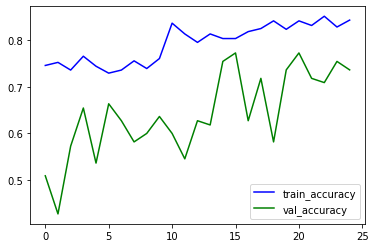

In [ ]:
hist=history_aug.history
plt.plot(hist["accuracy"],color="b",label="train_accuracy")
plt.plot(hist["val_accuracy"],color="g",label="val_accuracy")
plt.legend(loc="lower right")
plt.show()

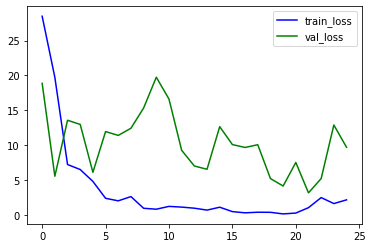

In [ ]:
#Loss curve
hist=history.history
plt.plot(hist["loss"],color="b",label="train_loss")
plt.plot(hist["val_loss"],color="g",label="val_loss")
plt.legend(loc="upper right")
plt.show()

In [ ]:
model_aug.evaluate(train_data_aug)

19/19 [==============================] - 17s 899ms/step - loss: 0.3539 - accuracy: 0.8647 - auc: 0.9376


[0.3539339005947113, 0.8646864891052246, 0.9376415610313416]

In [ ]:
model_aug.evaluate(val_data)

4/4 [==============================] - 0s 66ms/step - loss: 1.5222 - accuracy: 0.7364 - auc: 0.8035


[1.522150993347168, 0.7363636493682861, 0.8034999966621399]

In [ ]:
model_aug.evaluate(test_data)

4/4 [==============================] - 1s 247ms/step - loss: 3.5990 - accuracy: 0.7818 - auc: 0.8030


[3.5990145206451416, 0.7818182110786438, 0.8029999732971191]

In [ ]:
y_test_pred_aug=model_aug.predict(test_data)

In [ ]:
y_true=pd.Series(test_data.classes)
y_true

0      0
1      0
2      0
3      0
4      0
      ..
105    1
106    0
107    0
108    0
109    0
Length: 110, dtype: int64

In [ ]:
auc_aug=metrics.roc_auc_score(y_true,y_test_pred_aug)
auc_aug

0.8

In [ ]:
print(len(y_test_pred_aug))
print(y_test_pred_aug[0])

110
[0.00016728]


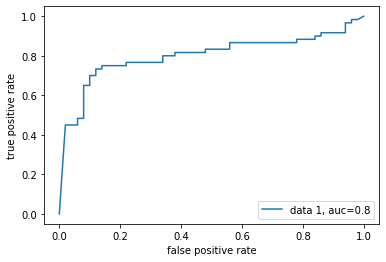

Threshold value is: 0.99973637


In [ ]:
# calculate roc curve
fpr_a, tpr_a, thresholds = metrics.roc_curve(y_true, y_test_pred_aug)

#plot roc curve
plt.plot(fpr_a,tpr_a,label="data 1, auc="+str(round(auc_aug,2)))
plt.ylabel('true positive rate')
plt.xlabel('false positive rate')
plt.legend(loc=4)
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

In [ ]:
print(thresholds)

[2.00000000e+00 1.00000000e+00 9.99991298e-01 9.99769509e-01
 9.99736369e-01 9.58132505e-01 8.95892322e-01 7.23263562e-01
 6.33138597e-01 3.72505814e-01 3.47194910e-01 3.41455370e-01
 2.11180627e-01 1.73702061e-01 8.40298906e-02 7.36332685e-02
 6.34968802e-02 5.67803755e-02 2.86600348e-02 2.28895955e-02
 1.38828205e-02 6.30460959e-03 1.66184236e-05 5.48836897e-06
 1.28535657e-06 1.17675299e-07 7.91472701e-08 4.96452444e-08
 1.71428233e-10 7.75869332e-13 4.49206617e-13 7.61962633e-15
 1.70042199e-22 0.00000000e+00]


[https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/](https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/)

In [ ]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr_a * (1-fpr_a))
gmeans

array([0.        , 0.66407831, 0.6503845 , 0.67404253, 0.66683331,
       0.7733046 , 0.76485293, 0.79372539, 0.78485667, 0.80332642,
       0.79414524, 0.80311892, 0.76485293, 0.7733046 , 0.71133677,
       0.72663608, 0.70427267, 0.71157103, 0.65166454, 0.65828059,
       0.60553007, 0.61752193, 0.43665394, 0.44083255, 0.37594326,
       0.37947332, 0.35496479, 0.35823642, 0.23452079, 0.24083189,
       0.19663842, 0.19832633, 0.14023789, 0.        ])

In [ ]:
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
optimal_threshold=thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (optimal_threshold, gmeans[ix]))

Best Threshold=0.372506, G-Mean=0.803


In [ ]:
y_test_pred_aug_index=[]
for i,pred in enumerate(y_test_pred_aug):
    if pred>=optimal_threshold:
        y_test_pred_aug_index.append(1)
    else:
        y_test_pred_aug_index.append(0)
# print(y_test_pred_aug_index)

In [ ]:
pd.Series(y_test_pred_aug_index).value_counts()

0    60
1    50
dtype: int64

In [ ]:
metrics.accuracy_score(y_true,y_test_pred_aug_index)

0.8

In [ ]:
cm_aug=confusion_matrix(y_true,y_test_pred_aug_index)

# Confusion matrix for augmentation

Confusion matrix, without normalization


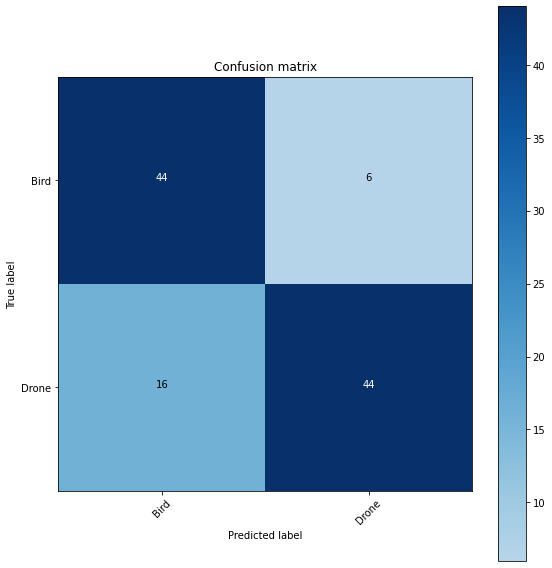

In [ ]:
plot_confusion_matrix(cm_aug,classes=categories)

### ClassWise accuracy with Augmentation

In [ ]:
class_wise_aug_acc=cm_aug.diagonal()/cm_aug.sum(axis=0)

In [ ]:
class_wise_aug_acc

array([0.72131148, 0.87755102])

In [ ]:
for i,cat in enumerate(categories):
    print(f'Class wise {cat} accuracy :{np.round(class_wise_aug_acc[i]*100,2)}')

Class wise Bird accuracy :72.13
Class wise Drone accuracy :87.76


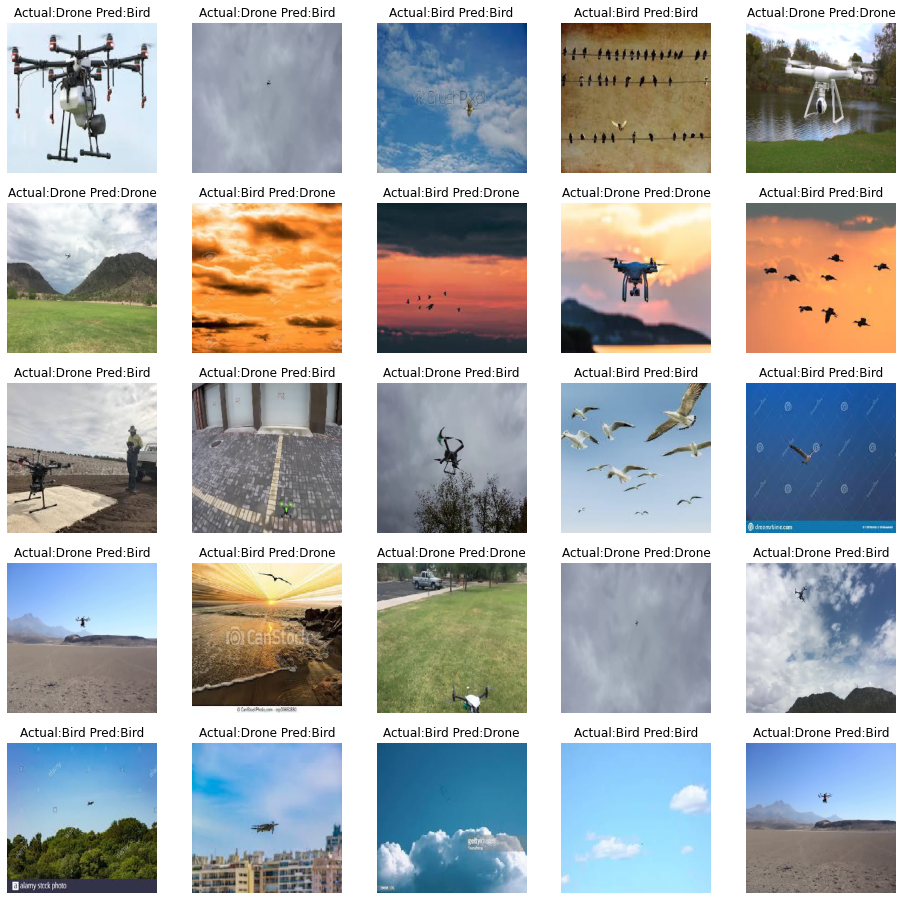

In [ ]:
w = 10
h = 10

label_dict={0:'Bird',1:'Drone'}

x= test_data.next()
image = x[0]      # img=x[0], label=x[1]
labels=x[1]
fig = plt.figure(figsize=(16, 16))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = image[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(f'Actual:{label_dict[int(labels[i])]} Pred:{label_dict[int(y_test_pred_aug_index[i])]}')
    plt.axis('off')
plt.show()

# Combine AUC

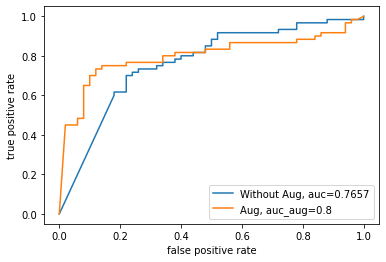

In [ ]:
#plot combine  roc curve

plt.plot(fpr,tpr,label="Without Aug, auc="+str(round(auc,4)))
plt.plot(fpr_a,tpr_a,label="Aug, auc_aug="+str(round(auc_aug,4)))
plt.ylabel('true positive rate')
plt.xlabel('false positive rate')
plt.legend(loc=4)
plt.show()


# Earlier results

In [ ]:
# barWidth = 0.25
# fig = plt.subplots(figsize =(12, 8))

# no_aug_test_acc=[23,30,47,46]
# aug_test_acc=[40,41,49,47]

# br1 = np.arange(len(no_aug_test_acc))
# br2 = [x + barWidth for x in br1]
 
# # Make the plot
# plt.bar(br1, no_aug_test_acc, color ='yellow', width = barWidth,
#         edgecolor ='grey', label ='No_Aug_Test_acc')
# plt.bar(br2, aug_test_acc, color ='brown', width = barWidth,
#         edgecolor ='grey', label ='Aug_Test_Acc')

# # Adding Xticks
# plt.xlabel('Image samples', fontweight ='bold', fontsize = 15)
# plt.ylabel('% Test accuracy', fontweight ='bold', fontsize = 15)
# plt.xticks([r + barWidth for r in range(len(no_aug_test_acc))],
#         ['200', '400', '600', '800'])
 
# plt.legend()
# plt.show()